In [5]:
import numpy as np
import types
import math
import torch
from torch._six import inf
from functools import wraps, partial
import warnings
import weakref
from collections import Counter
from bisect import bisect_right
from torch.optim.optimizer import Optimizer

# from torch.optimizer import Optimizer

from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt


In [6]:
class CustomizedCosineAnnealingWarmRestarts(_LRScheduler):
    def __init__(
        self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1.0, last_epoch=-1
    ):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CustomizedCosineAnnealingWarmRestarts, self).__init__(
            optimizer, last_epoch
        )
        self.T_cur = last_epoch

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [
                (self.eta_max - base_lr) * self.T_cur / self.T_up + base_lr
                for base_lr in self.base_lrs
            ]
        else:
            return [
                base_lr
                + (self.eta_max - base_lr)
                * (
                    1
                    + math.cos(
                        math.pi * (self.T_cur - self.T_up) / (self.T_i - self.T_up)
                    )
                )
                / 2
                for base_lr in self.base_lrs
            ]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(
                        math.log(
                            (epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult
                        )
                    )
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (
                        self.T_mult - 1
                    )
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma ** self.cycle)
        self.last_epoch = math.floor(epoch)
        ####################################################################
        self._last_lr = [group["lr"] for group in self.optimizer.param_groups]
        ####################################################################
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group["lr"] = lr

In [15]:
total_epochs = 1000

first_cycle_ratio = 0.05 # 첫번째 주기의 num_step을 결정한다.
T_0 = int(total_epochs*first_cycle_ratio)    # num_steps of first cycle

warmup_ratio = 0.2  # 첫번째 주기의 num_steps로부터 warmup을 몇 step만큼 할지 결정한다.
T_up = int(T_0 * warmup_ratio)  # Num of Warmup_steps

lr = 1e-6   # minimum of learning rate (lr의 최솟값)
max_lr = 1e-3 # maximum of learning rate

T_mult = 2  # Increasing Factor for length of next cycle Sequentially (다음 주기의 num_steps을 몇으로 할지 곱해져서 결정한다.)
gamma = 0.5 # Decreasing Factor for max_lr of next cycle Sequentially (다음 주기의 max_lr을 몇으로 할지 곱해져서 결정한다.)


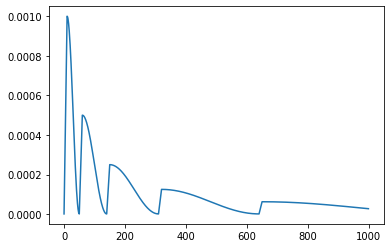

In [17]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
lr_sched = CustomizedCosineAnnealingWarmRestarts(
                                                optimizer, 
                                                T_0=T_0, 
                                                T_mult=T_mult, 
                                                eta_max=max_lr, 
                                                T_up=T_up, 
                                                gamma=gamma, 
                                                last_epoch=-1
    )


lrs = []

for i in range(total_epochs):
    lr_sched.step()
    lrs.append(
        optimizer.param_groups[0]["lr"]
    )

plt.plot(lrs)
